In [1]:
import datetime
import itertools
import os
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import roots_legendre
from tqdm.auto import tqdm

from dosipy.field import poynting
from dosipy.utils.dataloader import (load_antenna_el_properties,
                                     load_sphere_coords)
from dosipy.utils.derive import holoborodko
from dosipy.utils.integrate import elementwise_rectquad as equad
from dosipy.utils.viz import fig_config, save_fig, set_colorblind

In [2]:
print(f'platform: {jax.lib.xla_bridge.get_backend().platform}')

platform: cpu


In [3]:
set_colorblind()
%config InlineBackend.figure_format = 'retina'

In [4]:
# utils

def cart2sph(x, y, z):
    """Return spherical given Cartesain coordinates."""
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    """Return Cartesian given Spherical coordinates."""
    x = r * jnp.cos(phi) * jnp.sin(theta)
    y = r * jnp.sin(phi) * jnp.sin(theta)
    z = r * jnp.cos(theta)
    return x, y, z


def sPDn_fn(f, d, p):
    """Return incident power density normal to the 3 plane and
    spherical surface."""
    assert f in [3.5, 6., 10., 26., 30., 60., 80., 100.]
    if f < 30:
        target_area = (2 / 100, 2 / 100)  # effective irradiated surface area, 4cm2
        scaler = 0.0168405
    else:
        target_area = (1 / 100, 1 / 100)  # effective irradiated surface area, 1cm2
        scaler = 0.026025
    A = target_area[0] * target_area[1]  # area of the effective irradiated surface
    
    # target coordinates for curved model
    data = load_sphere_coords(2312)  # spherical head model coordinates
    target_area_origin = (-target_area[0]/2, -target_area[1]/2)
    data_target = data[  # effective irradiated skin surface
        (data['y'] <= 0) &
        (data['x'] >= target_area_origin[0]) &
        (data['x'] <= target_area_origin[0] * -1) &
        (data['z'] >= target_area_origin[1]) &
        (data['z'] <= target_area_origin[1] * -1)]
    data_target.reset_index(drop=True, inplace=True)
    xt_spherical = data_target['x'].to_numpy()
    yt_spherical = data_target['y'].to_numpy()
    zt_spherical = data_target['z'].to_numpy()
    
    # source data
    f = f * 1e9
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    Is = jnp.asarray(Is)
    xs = antenna_data.x.to_numpy()
    xs = jnp.asarray(xs)
    xs = xs - xs.max() / 2
    ys = jnp.zeros_like(xs) + data_target['y'].min() + d
    zs = jnp.zeros_like(xs)
    dx = xs[1] - xs[0]
    Is_x = holoborodko(Is, dx)
    
    # target coordinates for planar model
    xt_planar = jnp.linspace(-target_area[0] / 2, target_area[0] / 2, p)
    yt_planar_near = yt_spherical.min()
    yt_planar_far = yt_spherical.max()
    yt_planar_mid = (yt_planar_far + yt_planar_near) / 2
    zt_planar = jnp.linspace(-target_area[1] / 2, target_area[1] / 2, p)
        
    # incident power density for planar model
    S_planar_near = np.empty((xt_planar.size, zt_planar.size))
    S_planar_mid = np.empty_like(S_planar_near)
    S_planar_far = np.empty_like(S_planar_near)
    for xi, _xt in enumerate(xt_planar):
        for zi, _zt in enumerate(zt_planar):
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_near, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_near[xi, zi] = -_Sy.real
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_mid, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_mid[xi, zi] = -_Sy.real
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_far, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_far[xi, zi] = -_Sy.real
    sPDn_planar_near = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_near)
    sPDn_planar_mid = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_mid)
    sPDn_planar_far = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_far)   

    # generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
    _, theta, phi = cart2sph(xt_spherical, yt_spherical, zt_spherical)
    theta_a = theta.min()
    theta_b = theta.max()
    theta_range = (theta_b - theta_a) * scaler
    theta_a = theta_a - theta_range
    theta_b = theta_b + theta_range
    phi_a = phi.min()
    phi_b = phi.max()
    phi_range = (phi_b - phi_a) * scaler
    phi_a = phi_a - phi_range
    phi_b = phi_b + phi_range
    theta_points, theta_weights = roots_legendre(p)
    phi_points, phi_weights = roots_legendre(p)
    theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
    theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
    phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
    phi_weights = 0.5 * phi_weights * (phi_b - phi_a)
    r = 0.09
    
    # incident power density for curved model
    mag = 0
    A_spherical = 0
    for _theta, _w_theta in zip(theta_points, theta_weights):
        for _phi, _w_phi in zip(phi_points, phi_weights):
            # normal vector components
            nx = r ** 2 * jnp.cos(_phi) * jnp.sin(_theta) ** 2 
            ny = r ** 2 * jnp.sin(_phi) * jnp.sin(_theta) ** 2
            nz = r ** 2 * jnp.cos(_theta) * jnp.sin(_theta)
            # power density vector field
            _xt, _yt, _zt = sph2cart(r, _theta, _phi)
            _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
            # dot product between power density and normal vector
            Sn = _Sx.real * nx + _Sy.real * ny + _Sz.real * nz
            # Gaussian quadrature
            mag += Sn * _w_theta * _w_phi
            A_spherical += jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
    sPDn_spherical = mag / (2 * A_spherical)
    return sPDn_planar_near, sPDn_planar_mid, sPDn_planar_far, sPDn_spherical


def sPDtot_fn(f, d, p):
    """Return the norm incident power density on the 3 plane and
    spherical surface."""
    assert f in [3.5, 6., 10., 26., 30., 60., 80., 100.]
    if f < 30:
        target_area = (2 / 100, 2 / 100)  # effective irradiated surface area, 4cm2
        scaler = 0.0168405
    else:
        target_area = (1 / 100, 1 / 100)  # effective irradiated surface area, 1cm2
        scaler = 0.026025
    A = target_area[0] * target_area[1]  # area of the effective irradiated surface
    
    # target coordinates for curved model
    data = load_sphere_coords(2312)  # spherical head model coordinates
    target_area_origin = (-target_area[0]/2, -target_area[1]/2)
    data_target = data[  # effective irradiated skin surface
        (data['y'] <= 0) &
        (data['x'] >= target_area_origin[0]) &
        (data['x'] <= target_area_origin[0] * -1) &
        (data['z'] >= target_area_origin[1]) &
        (data['z'] <= target_area_origin[1] * -1)]
    data_target.reset_index(drop=True, inplace=True)
    xt_spherical = data_target['x'].to_numpy()
    yt_spherical = data_target['y'].to_numpy()
    zt_spherical = data_target['z'].to_numpy()
    
    # source data
    f = f * 1e9
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    Is = jnp.asarray(Is)
    xs = antenna_data.x.to_numpy()
    xs = jnp.asarray(xs)
    xs = xs - xs.max() / 2
    ys = jnp.zeros_like(xs) + data_target['y'].min() + d
    zs = jnp.zeros_like(xs)
    dx = xs[1] - xs[0]
    Is_x = holoborodko(Is, dx)
    
    # target coordinates for planar model
    xt_planar = jnp.linspace(-target_area[0] / 2, target_area[0] / 2, p)
    yt_planar_near = yt_spherical.min()
    yt_planar_far = yt_spherical.max()
    yt_planar_mid = (yt_planar_far + yt_planar_near) / 2
    zt_planar = jnp.linspace(-target_area[1] / 2, target_area[1] / 2, p)
        
    # incident power density for planar model
    S_planar_near = np.empty((xt_planar.size, zt_planar.size), dtype=np.complex64)
    S_planar_mid = np.empty_like(S_planar_near)
    S_planar_far = np.empty_like(S_planar_near)
    for xi, _xt in enumerate(xt_planar):
        for zi, _zt in enumerate(zt_planar):
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_near, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_near[xi, zi] = jnp.sqrt(_Sx.real ** 2 + _Sy.real ** 2 + _Sz.real ** 2)
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_mid, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_mid[xi, zi] = jnp.sqrt(_Sx.real ** 2 + _Sy.real ** 2 + _Sz.real ** 2)
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_far, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_far[xi, zi] = jnp.sqrt(_Sx.real ** 2 + _Sy.real ** 2 + _Sz.real ** 2)
    sPDtot_planar_near = 1 / (2 * A) * equad(xt_planar, zt_planar, abs(S_planar_near))
    sPDtot_planar_mid = 1 / (2 * A) * equad(xt_planar, zt_planar, abs(S_planar_mid))
    sPDtot_planar_far = 1 / (2 * A) * equad(xt_planar, zt_planar, abs(S_planar_far))
    
    
    # generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
    _, theta, phi = cart2sph(xt_spherical, yt_spherical, zt_spherical)
    theta_a = theta.min()
    theta_b = theta.max()
    theta_range = (theta_b - theta_a) * scaler
    theta_a = theta_a - theta_range
    theta_b = theta_b + theta_range
    phi_a = phi.min()
    phi_b = phi.max()
    phi_range = (phi_b - phi_a) * scaler
    phi_a = phi_a - phi_range
    phi_b = phi_b + phi_range
    theta_points, theta_weights = roots_legendre(p)
    phi_points, phi_weights = roots_legendre(p)
    theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
    theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
    phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
    phi_weights = 0.5 * phi_weights * (phi_b - phi_a)
    r = 0.09
    
    # incident power density for curved model
    mag = 0
    A_spherical = 0
    for _theta, _w_theta in zip(theta_points, theta_weights):
        for _phi, _w_phi in zip(phi_points, phi_weights):
            # power density vector field
            _xt, _yt, _zt = sph2cart(r, _theta, _phi)
            _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
            Sabs = jnp.sqrt(_Sx.real ** 2 + _Sy.real ** 2 + _Sz.real ** 2)
            dA = jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
            # Gaussian quadrature
            mag += Sabs * dA
            A_spherical += dA
    sPDtot_spherical = mag / (2 * A_spherical)
    return sPDtot_planar_near, sPDtot_planar_mid, sPDtot_planar_far, sPDtot_spherical

# Analysis

In [5]:
ds = np.array([2, 5, 10, 50, 150]) / -1000. # distance from the antenna
fs = np.array([3.5, 6., 10., 30., 60., 100.])  # frequencies in GHz
p = 11  # number of root points

## Incident power density (normal component), $sPDn$, between 3 planar and a spherical tissue model

In [6]:
try:
    date = '2022-05-23'
    sPDn_comp = np.load(os.path.join('analysis', f'sPDn_sim_{date}.npy'))
    sPDn_comp_r = np.delete(sPDn_comp, np.where(sPDn_comp == -0.1)[0], axis=0)
    ds_r = np.delete(ds, np.where(ds == -0.1)[0])
except:
    sPDn_comp = np.zeros((ds.size * fs.size, 7))
    i = 0
    for d, f in tqdm(list(itertools.product(ds, fs))):
        sPDn_planar_near, sPDn_planar_mid, sPDn_planar_far, sPDn_spherical = sPDn_fn(f, d, p)
        sPDn_comp[i, :] = [f, d, p, sPDn_planar_near, sPDn_planar_mid, sPDn_planar_far, sPDn_spherical]
        i += 1
    np.save(os.path.join('analysis', f'sPDn_sim_{datetime.date.today()}.npy'), sPDn_comp)
    ds_r = ds.copy()
    sPDn_comp_r = sPDn_comp.copy()

planar @ 3.5 GHz: [5.99 4.73 2.75 0.22 0.03]
spherical @ 3.5 GHz: [6.42 4.93 2.78 0.22 0.03]
planar @ 6.0 GHz: [7.47 5.33 2.99 0.22 0.03]
spherical @ 6.0 GHz: [8.3  5.54 3.03 0.22 0.03]
planar @ 10.0 GHz: [8.35 5.71 3.13 0.22 0.03]
spherical @ 10.0 GHz: [9.39 5.96 3.18 0.22 0.03]
planar @ 30.0 GHz: [26.18 12.73  4.78  0.23  0.03]
spherical @ 30.0 GHz: [27.18 12.93  4.81  0.23  0.03]
planar @ 60.0 GHz: [26.26 12.85  4.81  0.23  0.03]
spherical @ 60.0 GHz: [27.31 13.06  4.83  0.23  0.03]
planar @ 100.0 GHz: [26.25 12.87  4.81  0.23  0.03]
spherical @ 100.0 GHz: [27.3  13.08  4.84  0.23  0.03]


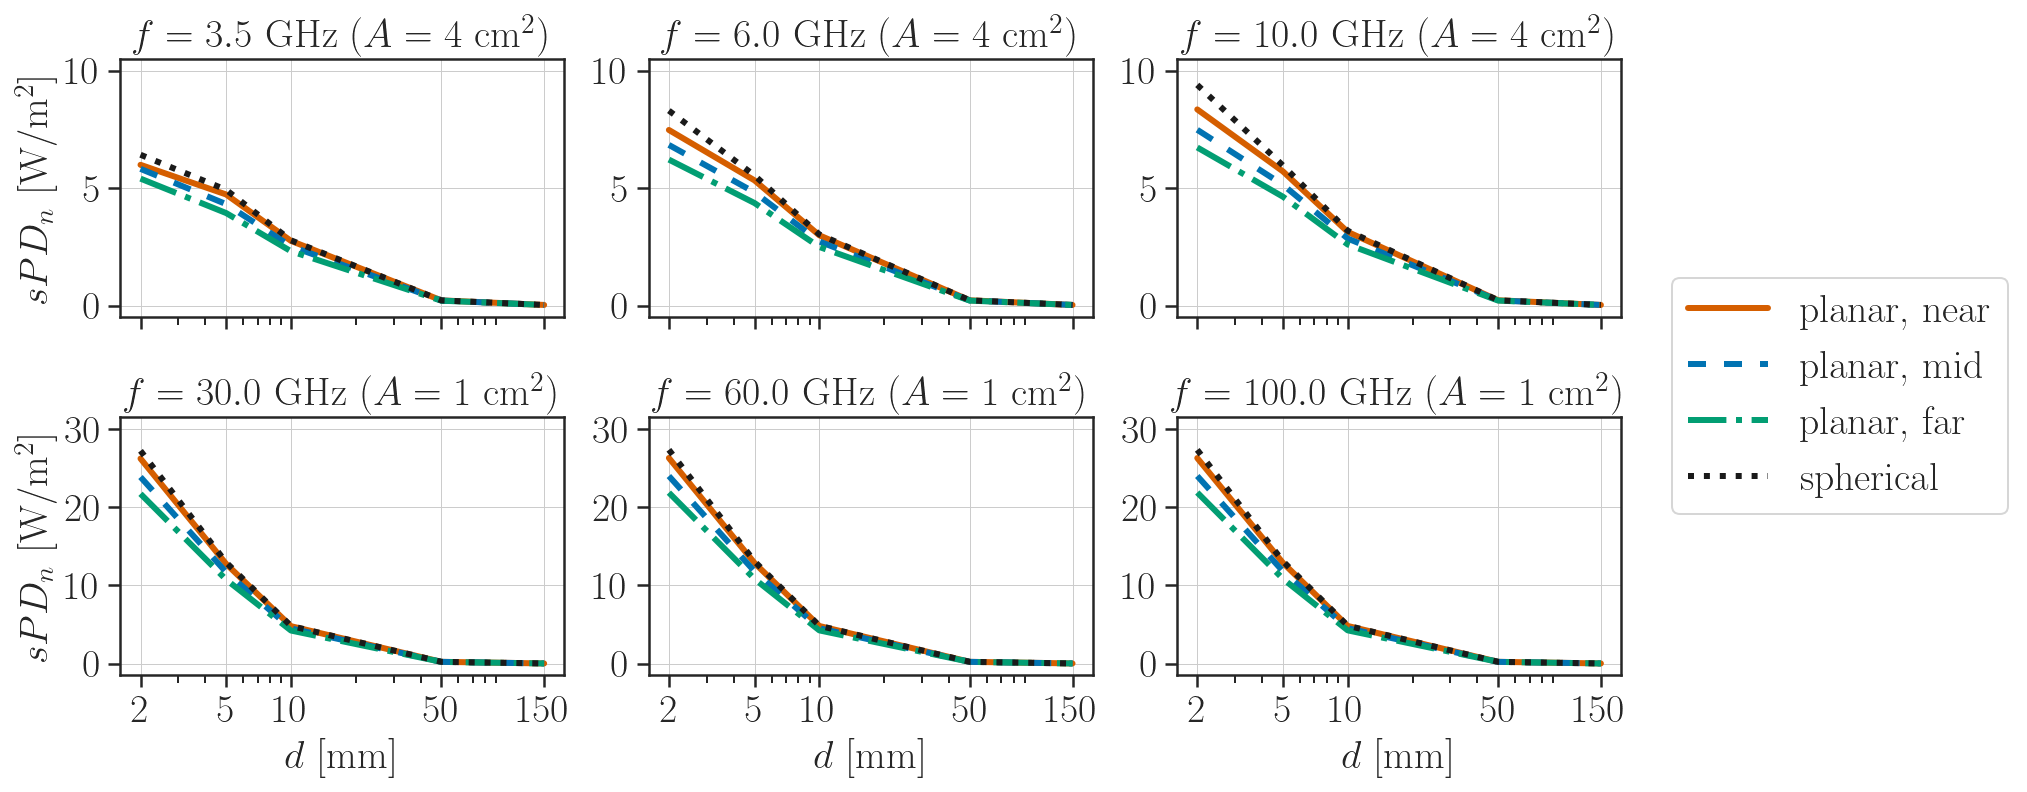

In [7]:
# visualize sPDn for planar models and the spherical model w.r.t. distances for range of frequencies

n_rows = 2
n_cols = 3
fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        print(f'planar @ {fs[f_idx]} GHz: {np.round(sPDn_comp_r[f_idx::fs.size, 3], 2)}')
        print(f'spherical @ {fs[f_idx]} GHz: {np.round(sPDn_comp_r[f_idx::fs.size, 6], 2)}')
        axs[row, col].plot(np.abs(ds_r), sPDn_comp_r[f_idx::fs.size, 3], 'r-', label='planar, near')
        axs[row, col].plot(np.abs(ds_r), sPDn_comp_r[f_idx::fs.size, 4], 'b--', label='planar, mid')
        axs[row, col].plot(np.abs(ds_r), sPDn_comp_r[f_idx::fs.size, 5], 'g-.', label='planar, far')
        axs[row, col].plot(np.abs(ds_r), sPDn_comp_r[f_idx::fs.size, 6], 'k:', label='spherical')
        axs[row, col].set_xscale('log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{n}$ [W/m$^2$]')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 10, 20, 30])
            axs[row, col].set_ylim([-1.5, 31.5])
        else:
            axs[row, col].set_yticks(ticks=[0, 5, 10])
            axs[row, col].set_ylim([-0.5, 10.5])
        if fs[f_idx] < 30.0:
            A = 4
        else:
            A = 1
        title = f'$f = {fs[f_idx]}$ GHz ($A = {A}$ cm$^2$)'
        axs[row, col].set_title(title)
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

#fname = os.path.join('figures', 'sPDn_sim')
#save_fig(fig, fname=fname)

near @ 3.5 GHz: [6.68 4.05 0.84 0.42 0.39]
far @ 3.5 GHz: [15.83      20.089998  16.72       5.72       1.8199999]
near @ 6.0 GHz: [9.919999   3.78       1.17       0.33999997 0.38      ]
far @ 6.0 GHz: [25.119999  21.21      17.58       5.87       1.8299999]
near @ 10.0 GHz: [11.11        4.24        1.54        0.30999997  0.38      ]
far @ 10.0 GHz: [28.349998 22.31     18.329998  5.93      1.84    ]
near @ 30.0 GHz: [3.6599998  1.5        0.53999996 0.01       0.07      ]
far @ 30.0 GHz: [20.21     17.039999 12.11      2.99      0.95    ]
near @ 60.0 GHz: [3.83       1.5799999  0.56999993 0.01       0.07      ]
far @ 60.0 GHz: [20.05     17.16     12.179999  2.99      0.95    ]
near @ 100.0 GHz: [3.84      1.6099999 0.58      0.01      0.07     ]
far @ 100.0 GHz: [19.96 17.18 12.2   2.99  0.95]


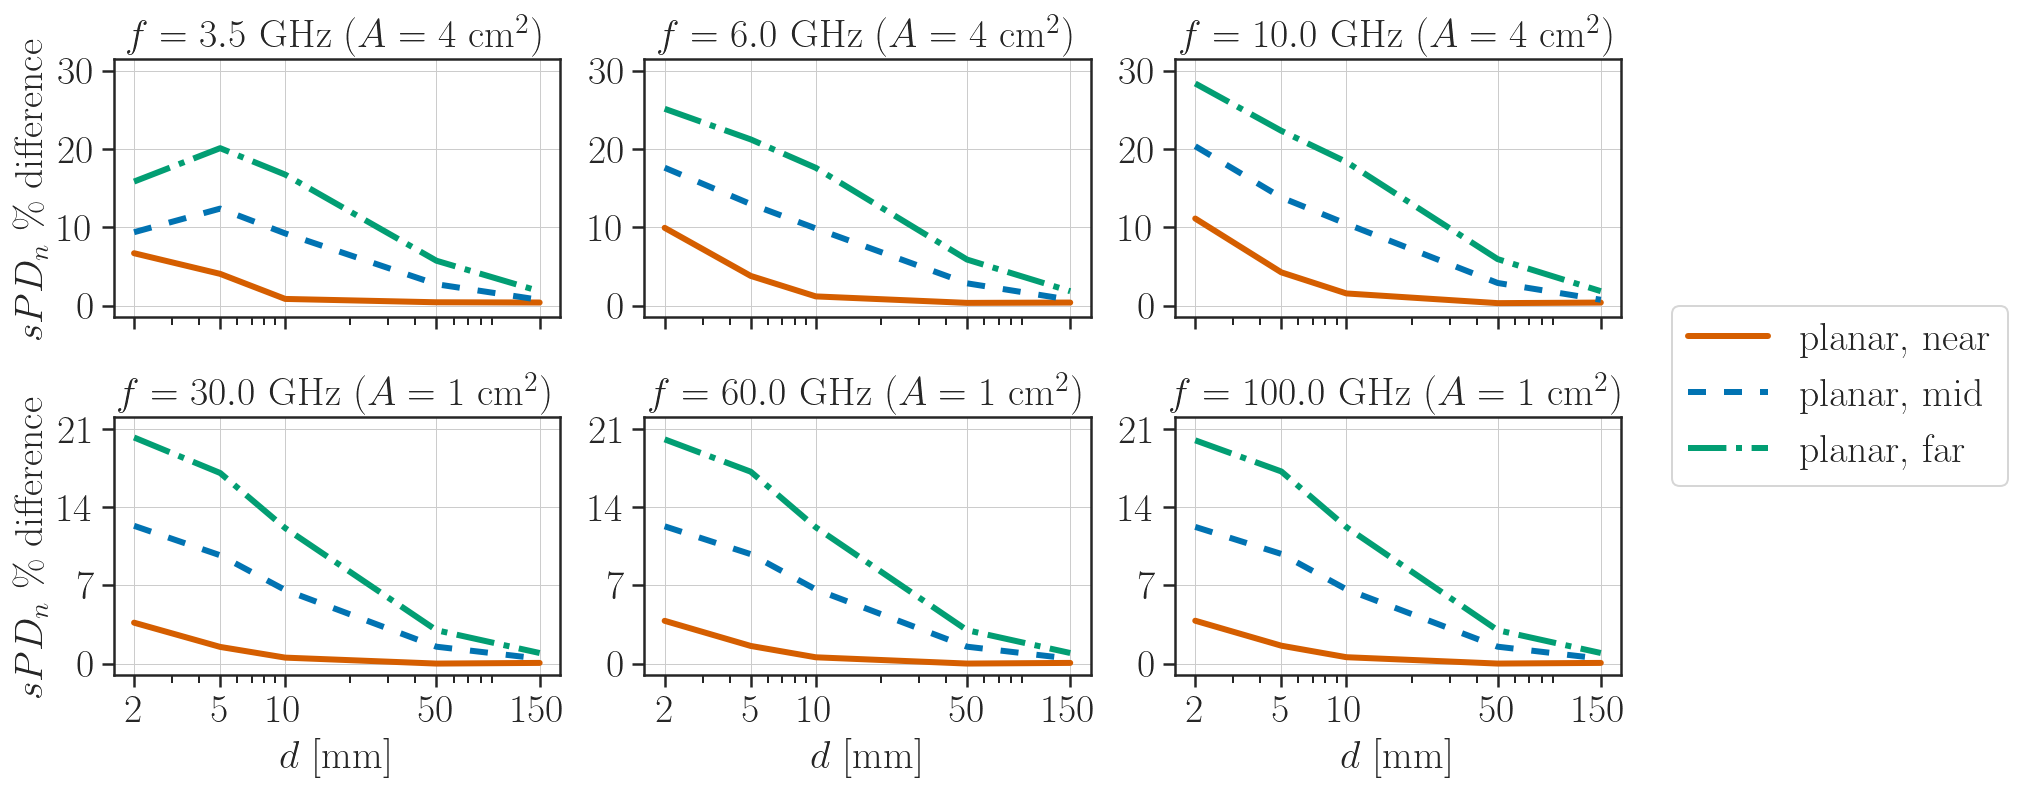

In [8]:
# visualize the absolute percentage difference in sPDn for planar models and the spherical model

fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        abs_diff_near = jnp.abs((sPDn_comp_r[f_idx::fs.size, 3] - sPDn_comp_r[f_idx::fs.size, 6]) / sPDn_comp_r[f_idx::fs.size, 6])
        abs_diff_mid = jnp.abs((sPDn_comp_r[f_idx::fs.size, 4] - sPDn_comp_r[f_idx::fs.size, 6]) / sPDn_comp_r[f_idx::fs.size, 6])
        abs_diff_far = jnp.abs((sPDn_comp_r[f_idx::fs.size, 5] - sPDn_comp_r[f_idx::fs.size, 6]) / sPDn_comp_r[f_idx::fs.size, 6])
        print(f'near @ {fs[f_idx]} GHz: {np.round(abs_diff_near, 4) * 100}')
        print(f'far @ {fs[f_idx]} GHz: {np.round(abs_diff_far, 4)  * 100}')
        axs[row, col].plot(np.abs(ds_r), abs_diff_near * 100, 'r-', label='planar, near')
        axs[row, col].plot(np.abs(ds_r), abs_diff_mid * 100, 'b--', label='planar, mid')
        axs[row, col].plot(np.abs(ds_r), abs_diff_far * 100, 'g-.', label='planar, far')
        axs[row, col].set_xscale('log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{n}$ \% difference')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 7, 14, 21])
            axs[row, col].set_ylim([-1.05, 22.05])
        else:
            axs[row, col].set_yticks(ticks=[0, 10, 20, 30])
            axs[row, col].set_ylim([-1.5, 31.5])
        if fs[f_idx] < 30.0:
            A = 4
        else:
            A = 1
        title = f'$f = {fs[f_idx]}$ GHz ($A = {A}$ cm$^2$)'
        axs[row, col].set_title(title)
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

#fname = os.path.join('figures', 'sPDn_rpd')
#save_fig(fig, fname=fname)

## Incident power density (the norm), $sPDtot$, between 3 planar and a spherical tissue model

In [9]:
try:
    date = '2022-05-23'
    sPDtot_comp = np.load(os.path.join('analysis', f'sPDtot_sim_{date}.npy'))
    sPDtot_comp_r = np.delete(sPDtot_comp, np.where(sPDtot_comp == -0.1)[0], axis=0)
    ds_r = np.delete(ds, np.where(ds == -0.1)[0])
except:
    sPDtot_comp = np.zeros((ds.size * fs.size, 7))
    i = 0
    for d, f in tqdm(list(itertools.product(ds, fs))):
        sPDtot_planar_near, sPDtot_planar_mid, sPDtot_planar_far, sPDtot_spherical = sPDtot_fn(f, d, p)
        sPDtot_comp[i, :] = [f, d, p, sPDtot_planar_near, sPDtot_planar_mid, sPDtot_planar_far, sPDtot_spherical]
        i += 1
    np.save(os.path.join('analysis', f'sPDtot_sim_{datetime.date.today()}.npy'), sPDtot_comp)
    ds_r = ds.copy()
    sPDtot_comp_r = sPDtot_comp.copy()

planar @ 3.5 GHz: [10.06  6.07  3.07  0.22  0.03]
spherical @ 3.5 GHz: [9.83 5.97 3.   0.22 0.03]
planar @ 6.0 GHz: [12.17  6.85  3.36  0.23  0.03]
spherical @ 6.0 GHz: [12.16  6.69  3.27  0.22  0.03]
planar @ 10.0 GHz: [13.52  7.4   3.56  0.23  0.03]
spherical @ 10.0 GHz: [13.64  7.24  3.46  0.22  0.03]
planar @ 30.0 GHz: [3.603e+01 1.457e+01 5.050e+00 2.300e-01 3.000e-02]
spherical @ 30.0 GHz: [3.604e+01 1.444e+01 5.010e+00 2.300e-01 3.000e-02]
planar @ 60.0 GHz: [3.648e+01 1.478e+01 5.090e+00 2.300e-01 3.000e-02]
spherical @ 60.0 GHz: [3.654e+01 1.465e+01 5.040e+00 2.300e-01 3.000e-02]
planar @ 100.0 GHz: [3.659e+01 1.482e+01 5.100e+00 2.300e-01 3.000e-02]
spherical @ 100.0 GHz: [3.664e+01 1.470e+01 5.050e+00 2.300e-01 3.000e-02]


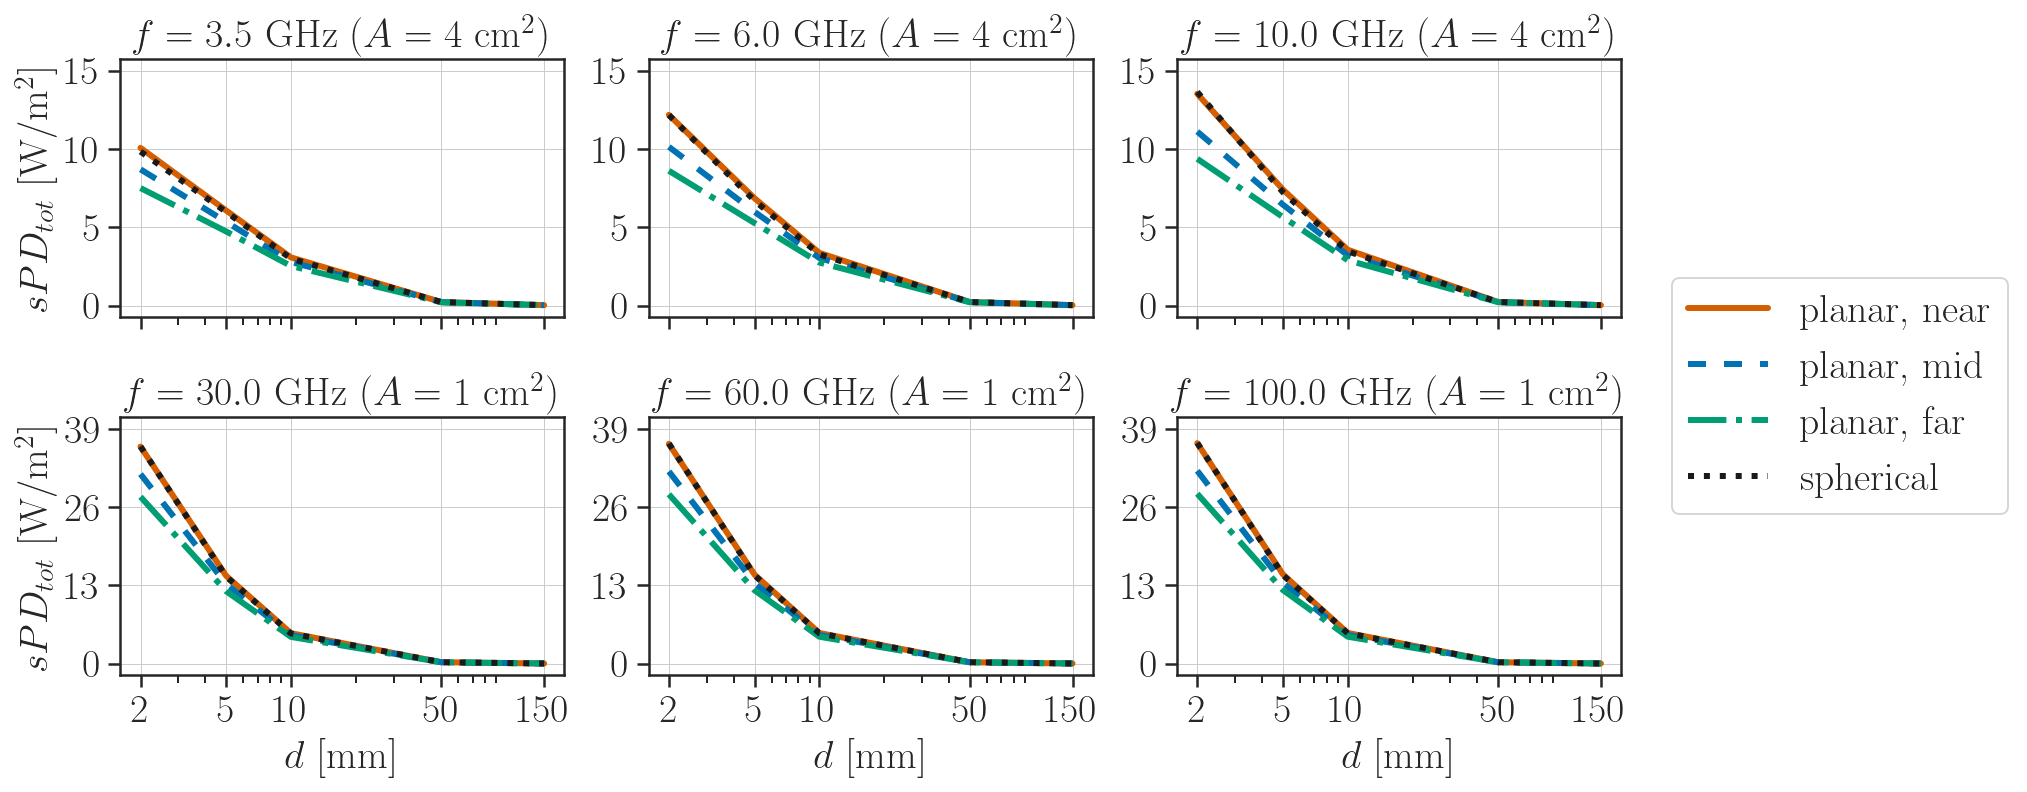

In [10]:
# visualize sPDtot for planar models and the spherical model w.r.t. distances for range of frequencies

n_rows = 2
n_cols = 3
fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        print(f'planar @ {fs[f_idx]} GHz: {np.round(sPDtot_comp_r[f_idx::fs.size, 3], 2)}')
        print(f'spherical @ {fs[f_idx]} GHz: {np.round(sPDtot_comp_r[f_idx::fs.size, 6], 2)}')
        axs[row, col].plot(np.abs(ds_r), sPDtot_comp_r[f_idx::fs.size, 3], 'r-', label='planar, near')
        axs[row, col].plot(np.abs(ds_r), sPDtot_comp_r[f_idx::fs.size, 4], 'b--', label='planar, mid')
        axs[row, col].plot(np.abs(ds_r), sPDtot_comp_r[f_idx::fs.size, 5], 'g-.', label='planar, far')
        axs[row, col].plot(np.abs(ds_r), sPDtot_comp_r[f_idx::fs.size, 6], 'k:', label='spherical')
        axs[row, col].set_xscale('log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{tot}$ [W/m$^2$]')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 13, 26, 39])
            axs[row, col].set_ylim([-1.95, 40.95])
        else:
            axs[row, col].set_yticks(ticks=[0, 5, 10, 15])
            axs[row, col].set_ylim([-0.75, 15.75])
        if fs[f_idx] < 30.0:
            A = 4
        else:
            A = 1
        title = f'$f = {fs[f_idx]}$ GHz ($A = {A}$ cm$^2$)'
        axs[row, col].set_title(title)
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

fname = os.path.join('figures', 'sPDtot_sim')
save_fig(fig, fname=fname)

near @ 3.5 GHz: [-2.39 -1.59 -2.58 -1.27 -0.45]
far @ 3.5 GHz: [23.68 20.82 15.71  4.97  1.76]
near @ 6.0 GHz: [-0.1  -2.33 -2.86 -1.29 -0.45]
far @ 6.0 GHz: [29.25 21.36 16.03  5.04  1.77]
near @ 10.0 GHz: [ 0.87 -2.29 -2.92 -1.3  -0.45]
far @ 10.0 GHz: [31.31 21.96 16.48  5.07  1.77]
near @ 30.0 GHz: [ 0.04 -0.88 -0.92 -0.25 -0.09]
far @ 30.0 GHz: [23.15 16.78 11.33  2.75  0.93]
near @ 60.0 GHz: [ 0.15 -0.85 -0.93 -0.25 -0.09]
far @ 60.0 GHz: [23.07 16.91 11.39  2.75  0.93]
near @ 100.0 GHz: [ 0.11 -0.84 -0.93 -0.25 -0.09]
far @ 100.0 GHz: [23.02 16.94 11.41  2.75  0.93]


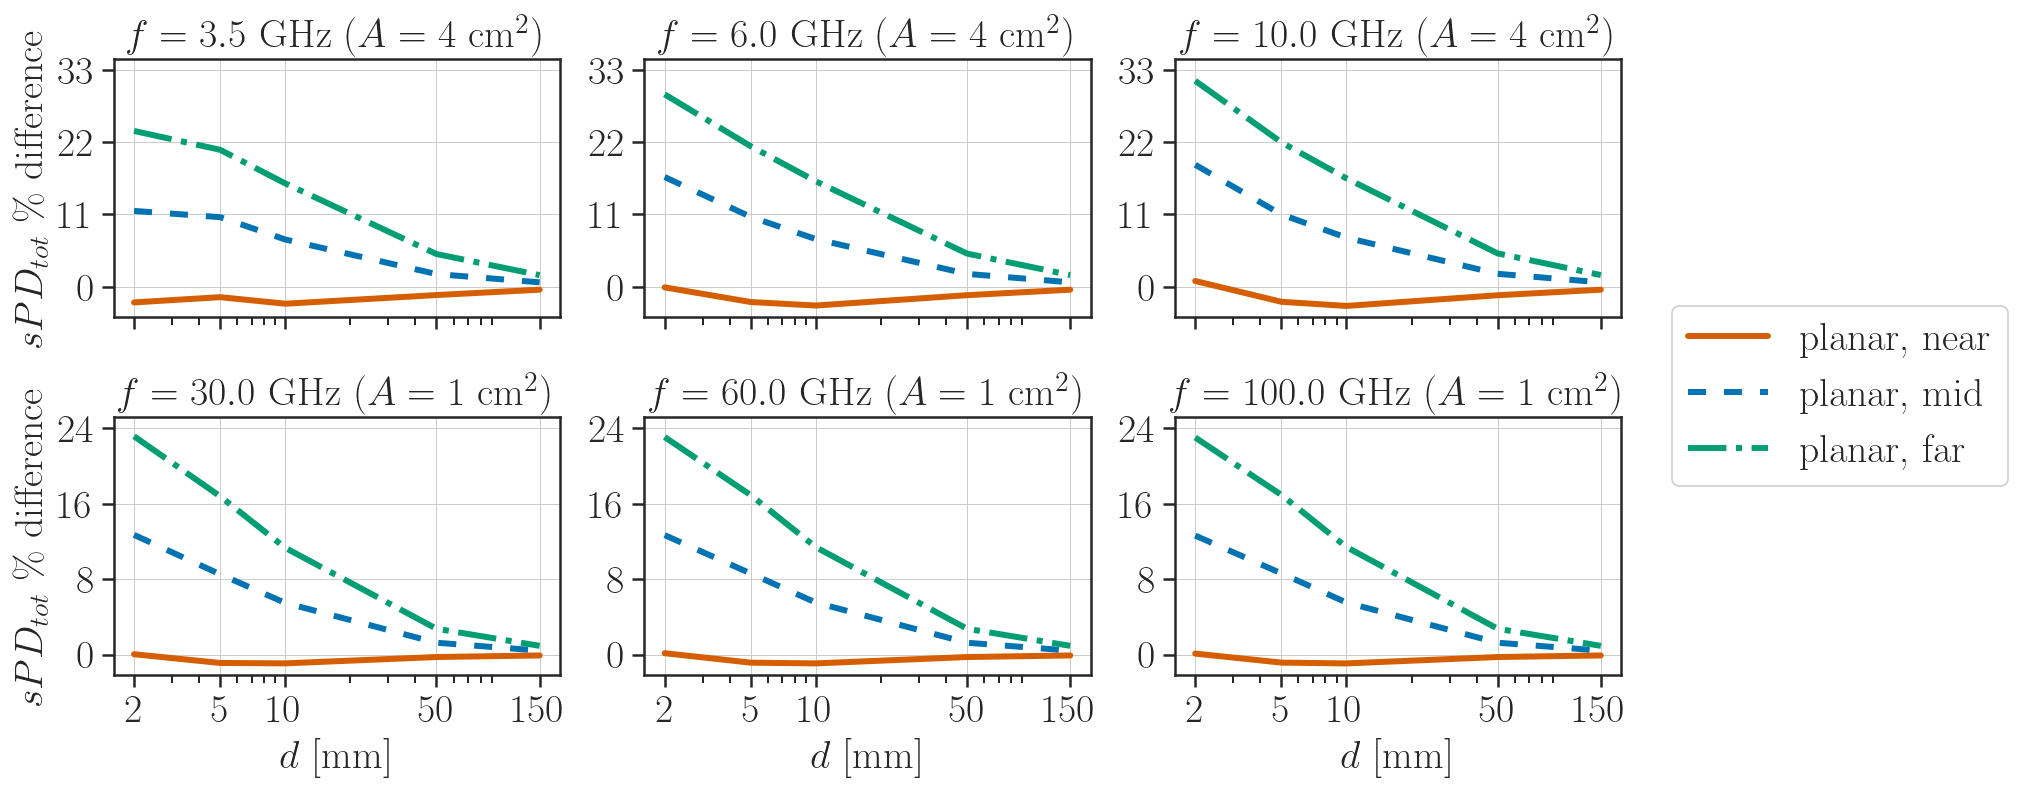

In [11]:
# visualize the absolute percentage difference in sPDn for planar models and the spherical model

fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        abs_diff_near = (sPDtot_comp_r[f_idx::fs.size, 6] - sPDtot_comp_r[f_idx::fs.size, 3]) / sPDtot_comp_r[f_idx::fs.size, 6]
        abs_diff_mid = (sPDtot_comp_r[f_idx::fs.size, 6] - sPDtot_comp_r[f_idx::fs.size, 4]) / sPDtot_comp_r[f_idx::fs.size, 6]
        abs_diff_far = (sPDtot_comp_r[f_idx::fs.size, 6] - sPDtot_comp_r[f_idx::fs.size, 5]) / sPDtot_comp_r[f_idx::fs.size, 6]
        print(f'near @ {fs[f_idx]} GHz: {np.round(abs_diff_near, 4) * 100}')
        print(f'far @ {fs[f_idx]} GHz: {np.round(abs_diff_far, 4)  * 100}')
        axs[row, col].plot(np.abs(ds_r), abs_diff_near * 100, 'r-', label='planar, near')
        axs[row, col].plot(np.abs(ds_r), abs_diff_mid * 100, 'b--', label='planar, mid')
        axs[row, col].plot(np.abs(ds_r), abs_diff_far * 100, 'g-.', label='planar, far')
        axs[row, col].set_xscale('log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{tot}$ \% difference')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 8, 16, 24])
            axs[row, col].set_ylim([-2.2, 25.2])
        else:
            axs[row, col].set_yticks(ticks=[0, 11, 22, 33])
            axs[row, col].set_ylim([-4.65, 34.65])
        if fs[f_idx] < 30.0:
            A = 4
        else:
            A = 1
        title = f'$f = {fs[f_idx]}$ GHz ($A = {A}$ cm$^2$)'
        axs[row, col].set_title(title)
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

#fname = os.path.join('figures', 'sPDtot_rpd')
#save_fig(fig, fname=fname)

## Spherical model, between $sPDn$ and $sPDtot$

In [12]:
f = 30

idx = np.where(sPDn_comp_r[:, 0] == f)[0]
diff = sPDtot_comp_r[idx, 6] - sPDn_comp_r[idx, 6]
ref = ((sPDtot_comp_r[idx, 6] + sPDn_comp_r[idx, 6]) / 2)
rel_diff = (diff / ref) * 100

In [13]:
np.set_printoptions(suppress=True)
print(f'd = {ds * -1000}')
print(f'sPDn = {sPDn_comp_r[idx, 6].round(2)}')
print(f'sPDtot = {sPDtot_comp_r[idx, 6].round(2)}')
print(f'abs diff = {diff.round(2)}')
print(f'rel diff = {rel_diff.round(2)}')

d = [  2.   5.  10.  50. 150.]
sPDn = [27.18 12.93  4.81  0.23  0.03]
sPDtot = [36.04 14.44  5.01  0.23  0.03]
abs diff = [8.86 1.51 0.2  0.   0.  ]
rel diff = [28.04 11.07  4.02  0.06  0.02]
